<a href="https://colab.research.google.com/github/plaban1981/Timeseries/blob/master/Machine_learning_Assignment__using_Auto_Timeseries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

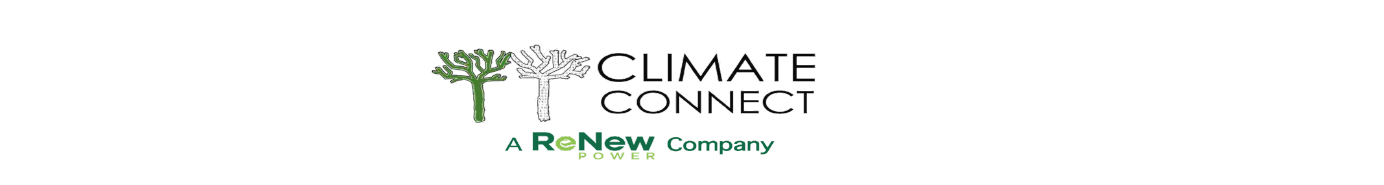

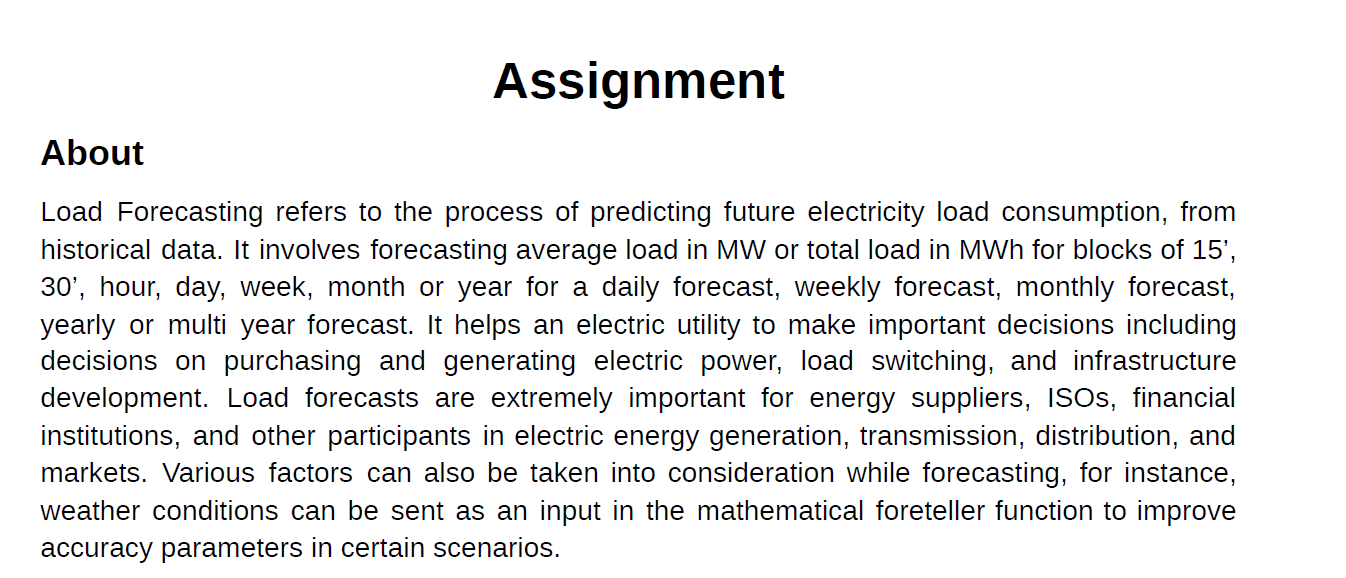

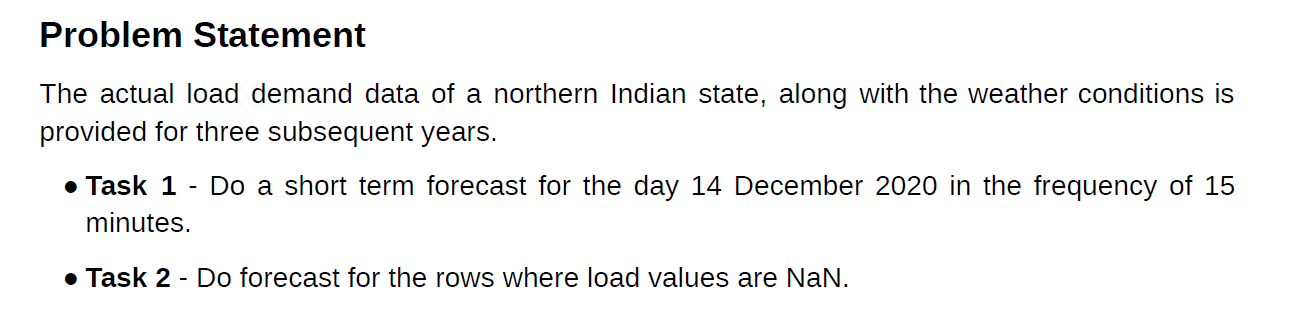

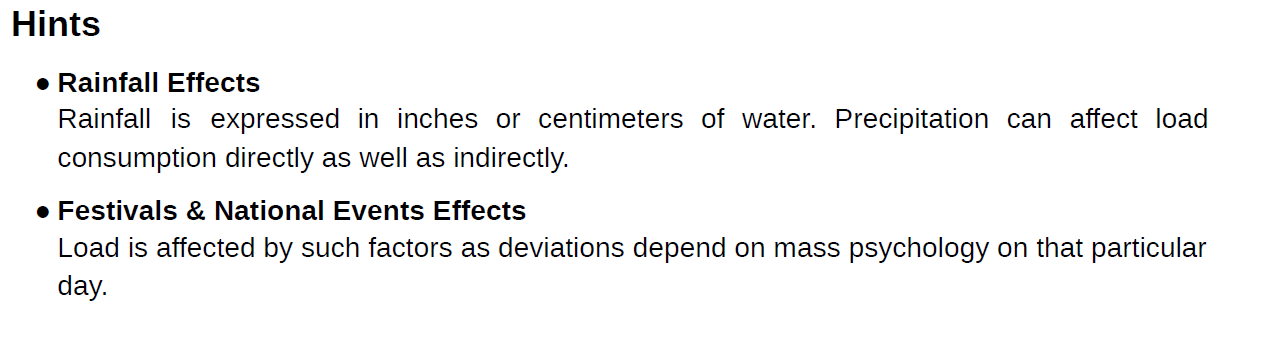

## Evaluation Metrics

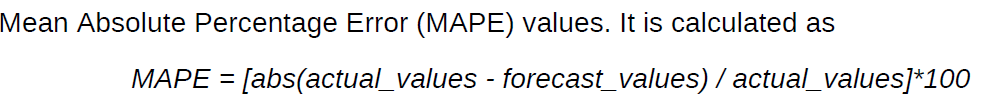

**Predict load**

In [2]:
import numpy as np
from fbprophet import Prophet
import pandas as pd
#
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
#
import seaborn as sns
import matplotlib.pyplot as plt
#
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight') # For plots
#
import warnings
warnings.filterwarnings('ignore')

In [3]:
from google.colab import drive
drive.mount("/content/drive")


Mounted at /content/drive


In [3]:
df = pd.read_csv("/content/drive/MyDrive/ZINDI/Assignment-MachineLearning(for candidates)/Assignment-MachineLearning/AssignmentData.csv",parse_dates =['datetime','date'])

## Schema 

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103584 entries, 0 to 103583
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   Unnamed: 0            103584 non-null  int64         
 1   datetime              103584 non-null  datetime64[ns]
 2   load                  101952 non-null  float64       
 3   apparent_temperature  103584 non-null  float64       
 4   temperature           103584 non-null  float64       
 5   humidity              103584 non-null  float64       
 6   dew_point             103584 non-null  float64       
 7   wind_speed            103584 non-null  float64       
 8   cloud_cover           103584 non-null  float64       
 9   date                  103584 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(7), int64(1)
memory usage: 7.9 MB


In [6]:
df.head()

,Unnamed: 0,datetime,load,apparent_temperature,temperature,humidity,dew_point,wind_speed,cloud_cover,date
0,0,2018-01-01 00:00:00,803.22270,10.45800,10.45800,0.955500,8.946000,0.0,0.0,2018-01-01
1,1,2018-01-01 00:15:00,774.89523,10.32675,10.32675,0.961625,8.911875,0.0,0.0,2018-01-01
2,2,2018-01-01 00:30:00,731.46927,10.19550,10.19550,0.967750,8.877750,0.0,0.0,2018-01-01
3,3,2018-01-01 00:45:00,713.93870,10.06425,10.06425,0.973875,8.843625,0.0,0.0,2018-01-01
4,4,2018-01-01 01:00:00,699.23007,9.93300,9.93300,0.980000,8.809500,0.0,0.0,2018-01-01


In [7]:
df.tail()

,Unnamed: 0,datetime,load,apparent_temperature,temperature,humidity,dew_point,wind_speed,cloud_cover,date
103579,103579,2020-12-14 22:45:00,NaN,12.450375,12.450375,0.611625,4.087125,1.9110,0.0000,2020-12-14
103580,103580,2020-12-14 23:00:00,NaN,12.285000,12.285000,0.619500,4.084500,1.8795,0.0000,2020-12-14
103581,103581,2020-12-14 23:15:00,NaN,13.650000,13.650000,0.829500,8.589000,2.4675,0.8925,2020-12-14
103582,103582,2020-12-14 23:30:00,NaN,13.650000,13.650000,0.829500,8.610000,2.4150,0.8925,2020-12-14
103583,103583,2020-12-14 23:45:00,NaN,13.387500,13.387500,0.840000,8.662500,2.4150,0.8610,2020-12-14


## Testing data is considered to be the data which has load as NULL values

In [4]:
test = df[df['load'].isnull()]

In [9]:
test.shape

(1632, 10)

In [10]:
df.shape

(103584, 10)

## Extract Training Data

In [5]:
train = df[~df['load'].isnull()]

In [6]:
train.shape

(101952, 10)

In [13]:
test.head()

,Unnamed: 0,datetime,load,apparent_temperature,temperature,humidity,dew_point,wind_speed,cloud_cover,date
48000,48000,2019-05-16 00:00:00,NaN,31.458000,31.458000,0.441000,16.56900,0.1365,0.462,2019-05-16
48001,48001,2019-05-16 00:15:00,NaN,31.371375,31.371375,0.443625,16.55325,0.1680,0.462,2019-05-16
48002,48002,2019-05-16 00:30:00,NaN,31.284750,31.284750,0.446250,16.53750,0.1995,0.462,2019-05-16
48003,48003,2019-05-16 00:45:00,NaN,31.198125,31.198125,0.448875,16.52175,0.2310,0.462,2019-05-16
48004,48004,2019-05-16 01:00:00,NaN,31.111500,31.111500,0.451500,16.50600,0.2625,0.462,2019-05-16


In [14]:
train.head()

,Unnamed: 0,datetime,load,apparent_temperature,temperature,humidity,dew_point,wind_speed,cloud_cover,date
0,0,2018-01-01 00:00:00,803.22270,10.45800,10.45800,0.955500,8.946000,0.0,0.0,2018-01-01
1,1,2018-01-01 00:15:00,774.89523,10.32675,10.32675,0.961625,8.911875,0.0,0.0,2018-01-01
2,2,2018-01-01 00:30:00,731.46927,10.19550,10.19550,0.967750,8.877750,0.0,0.0,2018-01-01
3,3,2018-01-01 00:45:00,713.93870,10.06425,10.06425,0.973875,8.843625,0.0,0.0,2018-01-01
4,4,2018-01-01 01:00:00,699.23007,9.93300,9.93300,0.980000,8.809500,0.0,0.0,2018-01-01


## Remove unwanted columns from training and test data

In [7]:
train = train.drop(['Unnamed: 0','date'],axis=1)
train.head()

,datetime,load,apparent_temperature,temperature,humidity,dew_point,wind_speed,cloud_cover
0,2018-01-01 00:00:00,803.22270,10.45800,10.45800,0.955500,8.946000,0.0,0.0
1,2018-01-01 00:15:00,774.89523,10.32675,10.32675,0.961625,8.911875,0.0,0.0
2,2018-01-01 00:30:00,731.46927,10.19550,10.19550,0.967750,8.877750,0.0,0.0
3,2018-01-01 00:45:00,713.93870,10.06425,10.06425,0.973875,8.843625,0.0,0.0
4,2018-01-01 01:00:00,699.23007,9.93300,9.93300,0.980000,8.809500,0.0,0.0


In [8]:
test = test.drop(['Unnamed: 0','date','load'],axis=1).reset_index()
test.drop('index',axis=1,inplace=True)
test.head()

,datetime,apparent_temperature,temperature,humidity,dew_point,wind_speed,cloud_cover
0,2019-05-16 00:00:00,31.458000,31.458000,0.441000,16.56900,0.1365,0.462
1,2019-05-16 00:15:00,31.371375,31.371375,0.443625,16.55325,0.1680,0.462
2,2019-05-16 00:30:00,31.284750,31.284750,0.446250,16.53750,0.1995,0.462
3,2019-05-16 00:45:00,31.198125,31.198125,0.448875,16.52175,0.2310,0.462
4,2019-05-16 01:00:00,31.111500,31.111500,0.451500,16.50600,0.2625,0.462


## Check for missing data if any in training data

In [9]:
train.isnull().sum()[train.isnull().sum() > 0]

Series([], dtype: int64)

* No missing data in the training sample

## Set Datetime as index for Timeseries plot

In [18]:
sample = train.set_index('datetime')
sample.head()

,load,apparent_temperature,temperature,humidity,dew_point,wind_speed,cloud_cover
datetime,,,,,,,
2018-01-01 00:00:00,803.22270,10.45800,10.45800,0.955500,8.946000,0.0,0.0
2018-01-01 00:15:00,774.89523,10.32675,10.32675,0.961625,8.911875,0.0,0.0
2018-01-01 00:30:00,731.46927,10.19550,10.19550,0.967750,8.877750,0.0,0.0
2018-01-01 00:45:00,713.93870,10.06425,10.06425,0.973875,8.843625,0.0,0.0
2018-01-01 01:00:00,699.23007,9.93300,9.93300,0.980000,8.809500,0.0,0.0


In [19]:
sample.resample('15min').mean().head(30)

,load,apparent_temperature,temperature,humidity,dew_point,wind_speed,cloud_cover
datetime,,,,,,,
2018-01-01 00:00:00,803.22270,10.458000,10.458000,0.955500,8.946000,0.000000,0.0
2018-01-01 00:15:00,774.89523,10.326750,10.326750,0.961625,8.911875,0.000000,0.0
2018-01-01 00:30:00,731.46927,10.195500,10.195500,0.967750,8.877750,0.000000,0.0
2018-01-01 00:45:00,713.93870,10.064250,10.064250,0.973875,8.843625,0.000000,0.0
2018-01-01 01:00:00,699.23007,9.933000,9.933000,0.980000,8.809500,0.000000,0.0
2018-01-01 01:15:00,684.37600,9.801750,9.801750,0.986125,8.775375,0.000000,0.0
2018-01-01 01:30:00,679.37650,9.670500,9.670500,0.992250,8.741250,0.000000,0.0
2018-01-01 01:45:00,671.21570,9.539250,9.539250,0.998375,8.707125,0.000000,0.0
2018-01-01 02:00:00,658.39577,9.408000,9.408000,1.004500,8.673000,0.000000,0.0


## Visualize Training Data for the given time span

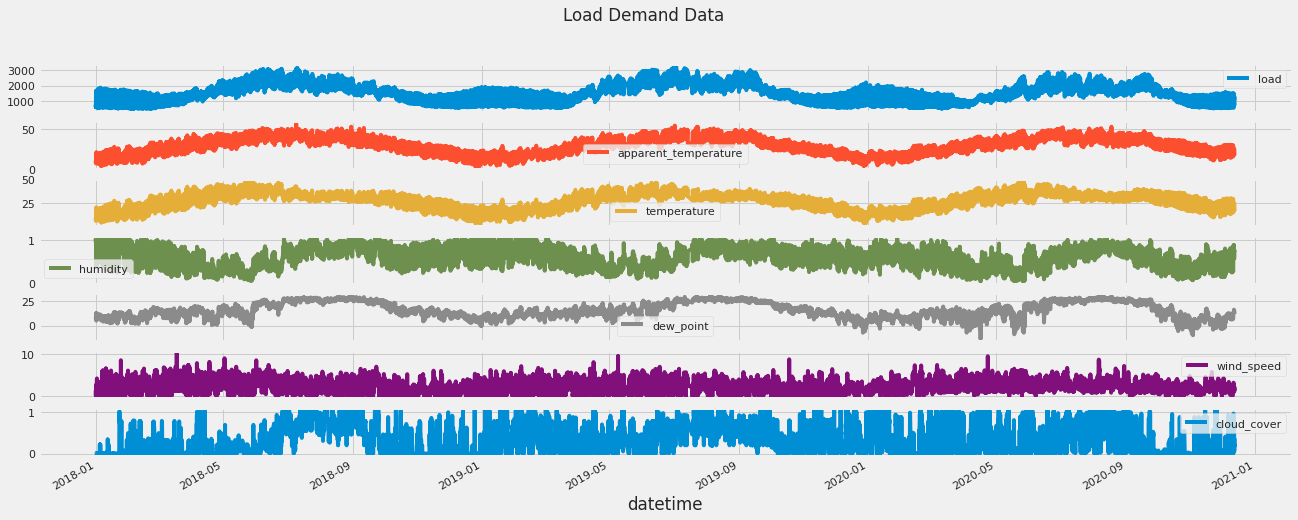

In [ ]:
sample.resample('15min').mean().plot(grid=True,title='Load Demand Data',figsize=(20,8),subplots=True)
plt.show()

## **Automate Time Series Forecasting using Auto-TS**

## Auto TimeSeries

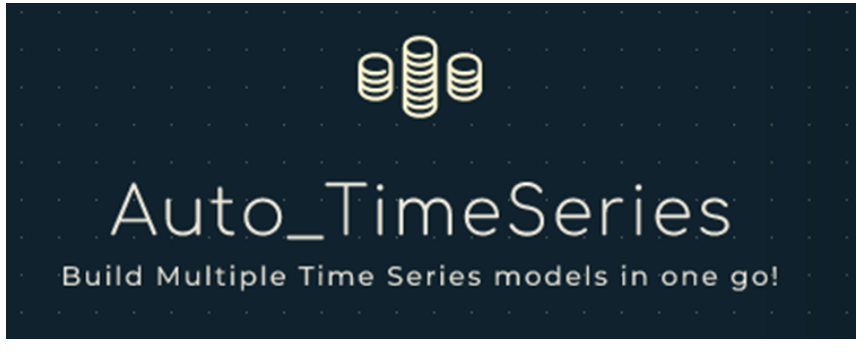

Auto-TS is an open-source Python library with time series forecasting implementation. 

It can train multiple time series forecasting models including ARIMA, SARIMAX, FB Prophet, VAR, etc, in just one line of Python code, and then choose the best one out of it for predictions.

#### Some of the features of Auto-TS libraries are:
* Finds the optimal time series forecasting model using genetic programming optimization.
* Trains naive, statistical, machine learning, and deep learning models, with all possible hyperparameter configurations, and cross-validation.
* Performs data transformations to handle messy data by learning optimal NaN imputation and outlier removal.
* Choice of the combination of metrics for model selection.

## **Install Auto Timeseries**

In [4]:
!pip install auto-ts

In [2]:
!pip install auto_ts

     |████████████████████████████████| 97 kB 5.3 MB/s 
     |████████████████████████████████| 1.4 MB 48.2 MB/s 
     |████████████████████████████████| 1.0 MB 47.9 MB/s 
     |████████████████████████████████| 9.8 MB 17.4 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
  Attempting uninstall: dask
    Found existing installation: dask 2.12.0
    Uninstalling dask-2.12.0:
      Successfully uninstalled dask-2.12.0


In [3]:
!pip install auto-ts --upgrade

In [1]:
!pip install dask[complete]

     |████████████████████████████████| 132 kB 10.1 MB/s 
     |████████████████████████████████| 802 kB 64.7 MB/s 
     |████████████████████████████████| 802 kB 34.2 MB/s 
     |████████████████████████████████| 793 kB 70.4 MB/s 
     |████████████████████████████████| 793 kB 71.0 MB/s 
     |████████████████████████████████| 791 kB 75.1 MB/s 
     |████████████████████████████████| 786 kB 70.8 MB/s 
     |████████████████████████████████| 779 kB 54.7 MB/s 
     |████████████████████████████████| 778 kB 68.1 MB/s 
     |████████████████████████████████| 776 kB 36.1 MB/s 
     |████████████████████████████████| 769 kB 70.6 MB/s 
     |████████████████████████████████| 766 kB 72.5 MB/s 
     |████████████████████████████████| 1.0 MB 63.7 MB/s 
     |████████████████████████████████| 722 kB 68.8 MB/s 
     |████████████████████████████████| 722 kB 74.3 MB/s 
     |████████████████████████████████| 715 kB 71.5 MB/s 
     |████████████████████████████████| 705 kB 65.8 MB/s 
     |████████

In [2]:
!pip install dask_xgboost

In [2]:
!pip install dask distributed --upgrade

  Using cached distributed-2021.12.0-py3-none-any.whl (802 kB)
  Attempting uninstall: distributed
    Found existing installation: distributed 2.30.1
    Uninstalling distributed-2.30.1:
      Successfully uninstalled distributed-2.30.1


## Import Auto Timeseries Library

In [10]:
from auto_ts import auto_timeseries

Imported auto_timeseries version:0.0.46. Call by using:
model = auto_timeseries(score_type='rmse',
        time_interval='M', non_seasonal_pdq=None, seasonality=False,
        seasonal_period=12, model_type=['best'], verbose=2, dask_xgboost_flag=0)
model.fit(traindata, ts_column,target)
model.predict(testdata, model='best')



## Initialize the Auto-TS model object to use the FB Prophet Model, and fit the training data.

In [20]:
model = auto_timeseries( score_type='rmse', 
                        time_interval='T,min',
                        non_seasonal_pdq=None, 
                        seasonality=True, 
                        seasonal_period=60, 
                        model_type=['Prophet'], 
                        verbose=2)

In [21]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101952 entries, 0 to 103391
Data columns (total 8 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   datetime              101952 non-null  datetime64[ns]
 1   load                  101952 non-null  float64       
 2   apparent_temperature  101952 non-null  float64       
 3   temperature           101952 non-null  float64       
 4   humidity              101952 non-null  float64       
 5   dew_point             101952 non-null  float64       
 6   wind_speed            101952 non-null  float64       
 7   cloud_cover           101952 non-null  float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 7.0 MB


In [22]:
train.head()

,datetime,load,apparent_temperature,temperature,humidity,dew_point,wind_speed,cloud_cover
0,2018-01-01 00:00:00,803.22270,10.45800,10.45800,0.955500,8.946000,0.0,0.0
1,2018-01-01 00:15:00,774.89523,10.32675,10.32675,0.961625,8.911875,0.0,0.0
2,2018-01-01 00:30:00,731.46927,10.19550,10.19550,0.967750,8.877750,0.0,0.0
3,2018-01-01 00:45:00,713.93870,10.06425,10.06425,0.973875,8.843625,0.0,0.0
4,2018-01-01 01:00:00,699.23007,9.93300,9.93300,0.980000,8.809500,0.0,0.0


Start of Fit.....
Running Augmented Dickey-Fuller test with paramters:
    maxlag: 31 regression: c autolag: BIC
Results of Augmented Dickey-Fuller Test:
+-----------------------------+------------------------------+
|                             | Dickey-Fuller Augmented Test |
+-----------------------------+------------------------------+
|        Test Statistic       |     -15.883436634196332      |
|           p-value           |    8.704767665249516e-29     |
|          #Lags Used         |             27.0             |
| Number of Observations Used |           101924.0           |
|     Critical Value (1%)     |      -3.430414160204652      |
|     Critical Value (5%)     |     -2.8615683578111595      |
|     Critical Value (10%)    |     -2.5667850938695476      |
+-----------------------------+------------------------------+
 this series is stationary
    Target variable given as = load
Start of loading of data.....
Input is data frame. Performing Time Series Analysis
ts_colu

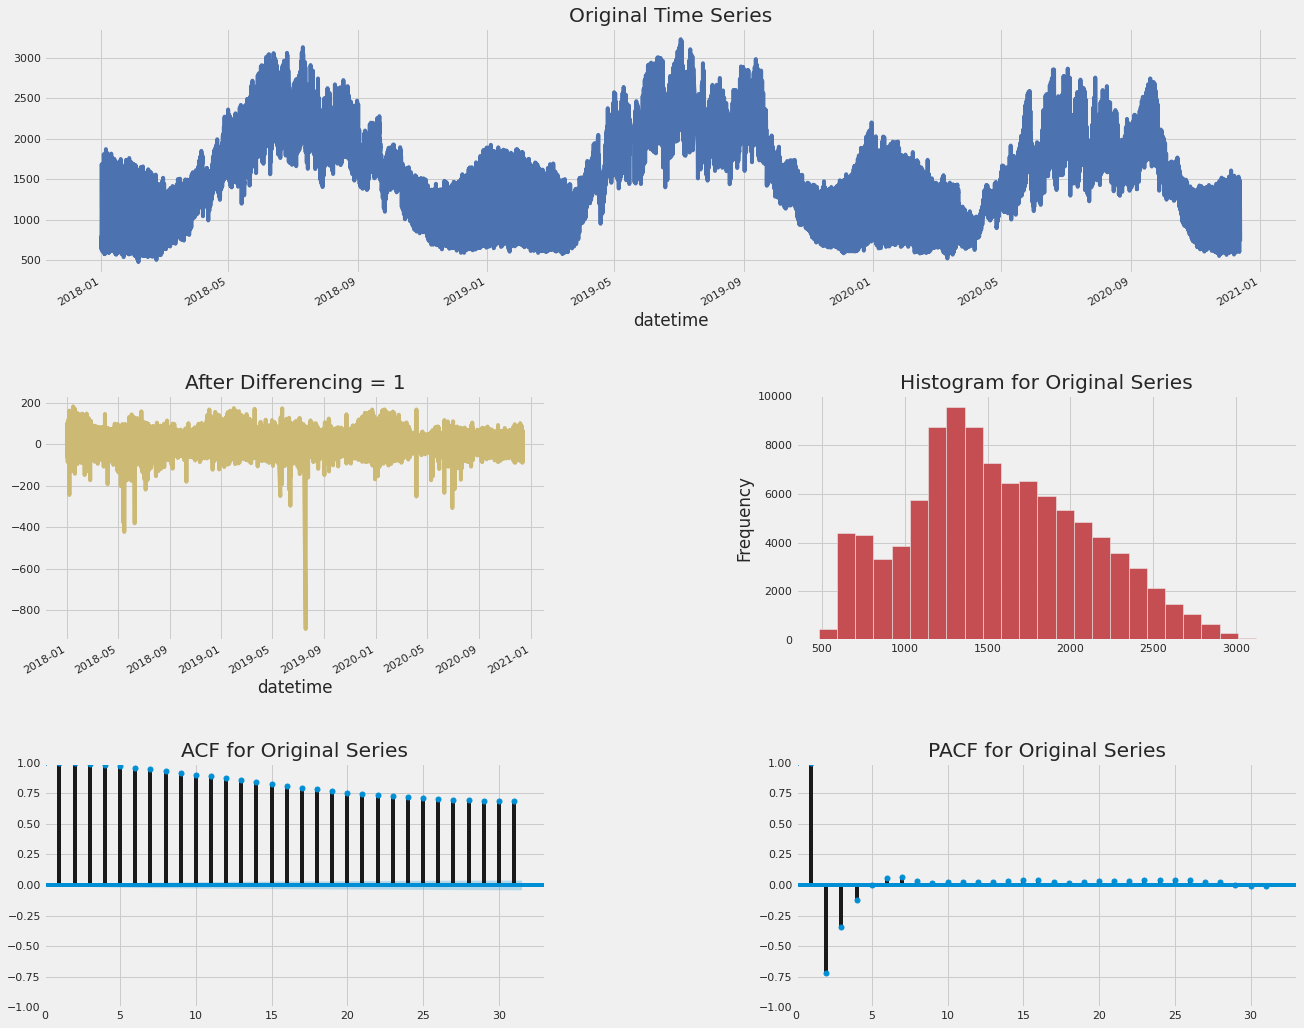

Time Interval is given as T,min
    Correct Time interval given as a valid Pandas date-range frequency...


Building Prophet Model



Running Facebook Prophet Model...
    Fit-Predict data (shape=(101952, 8)) with Confidence Interval = 0.95...
  Starting Prophet Fit
       Adding monthly seasonality to Prophet with period=60, fourier_order=12 and prior_scale=0.10
  Starting Prophet Cross Validation
Max. iterations using expanding window cross validation = 5

Fold Number: 1 --> Train Shape: 101927 Test Shape: 5
    RMSE = 13.79
    Std Deviation of actuals = 12.40
    Normalized RMSE (as pct of std dev) = 111%
Cross Validation window: 1 completed

Fold Number: 2 --> Train Shape: 101932 Test Shape: 5
    RMSE = 88.60
    Std Deviation of actuals = 22.41
    Normalized RMSE (as pct of std dev) = 395%
Cross Validation window: 2 completed

Fold Number: 3 --> Train Shape: 101937 Test Shape: 5
    RMSE = 212.96
    Std Deviation of actuals = 33.27
    Normalized RMSE (as pct of std dev) = 640

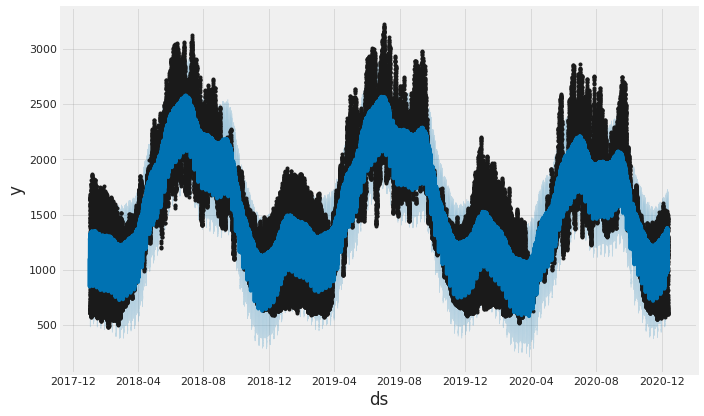

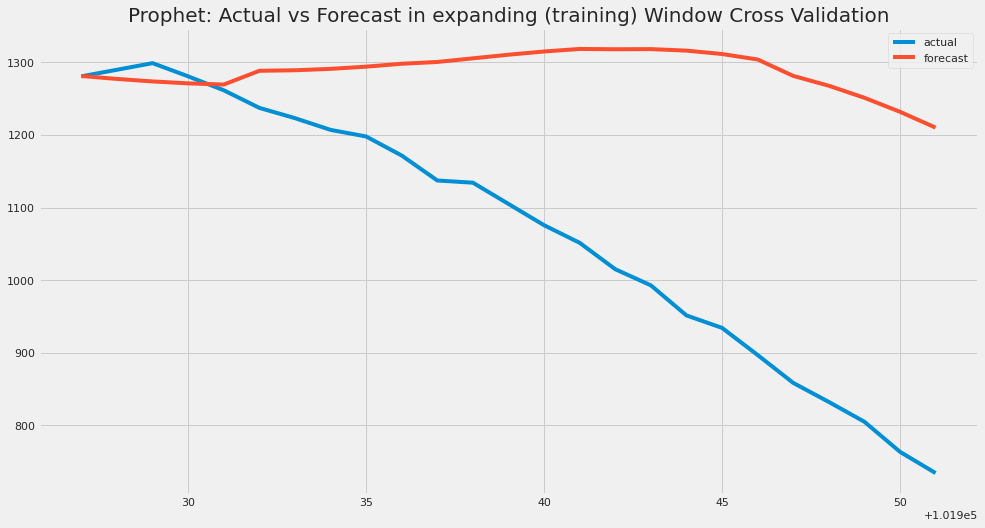

In [23]:
model.fit( traindata=train, ts_column="datetime", target="load", cv=5, sep="," )

In [25]:
model.get_leaderboard()

,name,rmse
0,Prophet,224.572795


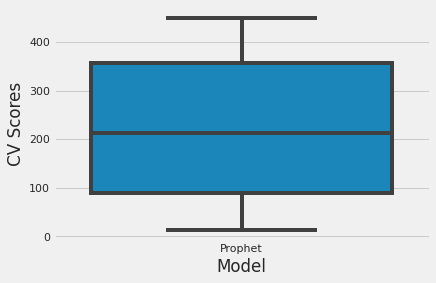

In [26]:

model.plot_cv_scores()

## Make Predictions on future data

In [28]:
test.head()

,datetime,apparent_temperature,temperature,humidity,dew_point,wind_speed,cloud_cover
0,2019-05-16 00:00:00,31.458000,31.458000,0.441000,16.56900,0.1365,0.462
1,2019-05-16 00:15:00,31.371375,31.371375,0.443625,16.55325,0.1680,0.462
2,2019-05-16 00:30:00,31.284750,31.284750,0.446250,16.53750,0.1995,0.462
3,2019-05-16 00:45:00,31.198125,31.198125,0.448875,16.52175,0.2310,0.462
4,2019-05-16 01:00:00,31.111500,31.111500,0.451500,16.50600,0.2625,0.462


In [30]:
future_predictions = model.predict(test)

Predicting using test dataframe as input for Prophet model
Building Forecast dataframe. Forecast Period = 1632


In [32]:
future_predictions[['ds','yhat_lower','yhat','yhat_upper']]

,ds,yhat_lower,yhat,yhat_upper
0,2019-05-16 00:00:00,1662.744813,1980.704214,2296.305734
1,2019-05-16 00:15:00,1631.738754,1956.453526,2288.874609
2,2019-05-16 00:30:00,1610.217189,1931.070560,2263.176825
3,2019-05-16 00:45:00,1588.949297,1905.104517,2216.167619
4,2019-05-16 01:00:00,1562.738539,1879.116146,2196.377400
...,...,...,...,...
1627,2020-12-14 22:45:00,1085.674646,1413.747143,1736.087903
1628,2020-12-14 23:00:00,1101.444371,1401.791127,1725.662915
1629,2020-12-14 23:15:00,1050.832398,1386.855748,1717.481514
1630,2020-12-14 23:30:00,1067.317065,1369.128699,1715.671910


## Initialize the Auto-TS model object to train on the best model, and fit the training data.

In [11]:
model = auto_timeseries( score_type='rmse', 
                        time_interval='T,min',
                        non_seasonal_pdq=None, 
                        seasonality=True, 
                        seasonal_period=60, 
                        model_type=['ARIMA','ML'], 
                        verbose=2)

Start of Fit.....
Running Augmented Dickey-Fuller test with paramters:
    maxlag: 31 regression: c autolag: BIC
Results of Augmented Dickey-Fuller Test:
+-----------------------------+------------------------------+
|                             | Dickey-Fuller Augmented Test |
+-----------------------------+------------------------------+
|        Test Statistic       |     -15.883436634196332      |
|           p-value           |    8.704767665249516e-29     |
|          #Lags Used         |             27.0             |
| Number of Observations Used |           101924.0           |
|     Critical Value (1%)     |      -3.430414160204652      |
|     Critical Value (5%)     |     -2.8615683578111595      |
|     Critical Value (10%)    |     -2.5667850938695476      |
+-----------------------------+------------------------------+
 this series is stationary
    Target variable given as = load
Start of loading of data.....
Input is data frame. Performing Time Series Analysis
ts_colu

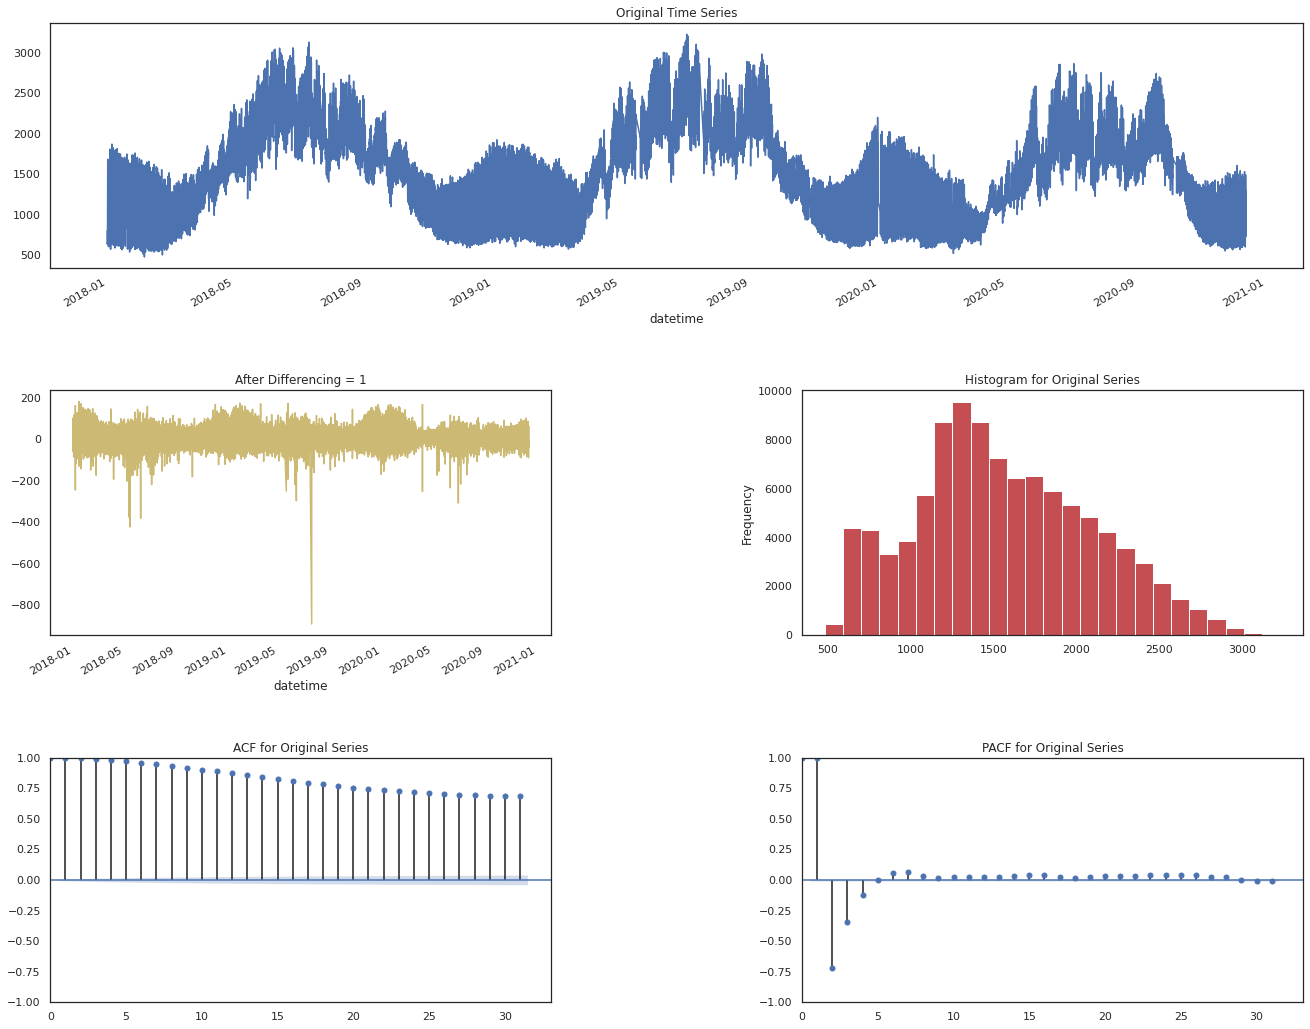

Time Interval is given as T,min
    Correct Time interval given as a valid Pandas date-range frequency...


UnboundLocalError: ignored

In [13]:
model.fit( traindata=train, ts_column="datetime", target="load" )